# Fish Image Classification Pipeline (Local)


## 1. Setup (Colab + Drive)


In [1]:
import os
import random
from pathlib import Path

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATASET_DIR = Path(r'D:\Download\FDM\FishImgDataset-20260109T102222Z-3-001\FishImgDataset')
TRAIN_DIR = DATASET_DIR / 'train'
VAL_DIR = DATASET_DIR / 'val'
TEST_DIR = DATASET_DIR / 'test'

TRAIN_DIR, VAL_DIR, TEST_DIR


c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


(WindowsPath('D:/Download/FDM/FishImgDataset-20260109T102222Z-3-001/FishImgDataset/train'),
 WindowsPath('D:/Download/FDM/FishImgDataset-20260109T102222Z-3-001/FishImgDataset/val'),
 WindowsPath('D:/Download/FDM/FishImgDataset-20260109T102222Z-3-001/FishImgDataset/test'))

## 2. Inspect data and class distribution


In [2]:
def count_images_per_class(root_dir: Path):
    counts = {}
    for class_dir in sorted([p for p in root_dir.iterdir() if p.is_dir()]):
        counts[class_dir.name] = len(list(class_dir.glob('*')))
    return counts

train_counts = count_images_per_class(TRAIN_DIR)
val_counts = count_images_per_class(VAL_DIR)
test_counts = count_images_per_class(TEST_DIR)

train_counts

{'Bangus': 171,
 'Big Head Carp': 201,
 'Black Spotted Barb': 200,
 'Catfish': 314,
 'Climbing Perch': 152,
 'Fourfinger Threadfin': 192,
 'Freshwater Eel': 273,
 'Glass Perchlet': 399,
 'Goby': 607,
 'Gold Fish': 206,
 'Gourami': 312,
 'Grass Carp': 1222,
 'Green Spotted Puffer': 110,
 'Indian Carp': 262,
 'Indo-Pacific Tarpon': 186,
 'Jaguar Gapote': 229,
 'Janitor Fish': 286,
 'Knifefish': 319,
 'Long-Snouted Pipefish': 256,
 'Mosquito Fish': 256,
 'Mudfish': 191,
 'Mullet': 174,
 'Pangasius': 193,
 'Perch': 293,
 'Scat Fish': 154,
 'Silver Barb': 329,
 'Silver Carp': 238,
 'Silver Perch': 285,
 'Snakehead': 232,
 'Tenpounder': 277,
 'Tilapia': 302}

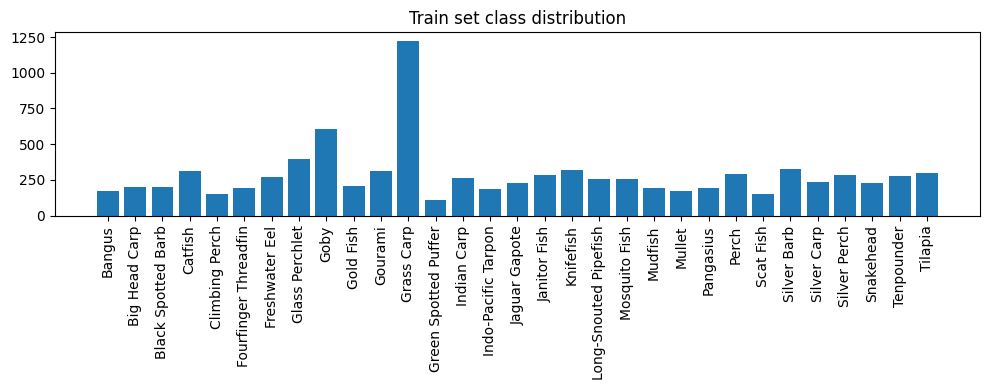

In [3]:
plt.figure(figsize=(10, 4))
plt.bar(train_counts.keys(), train_counts.values())
plt.xticks(rotation=90)
plt.title('Train set class distribution')
plt.tight_layout()
plt.show()

## 3. Data loading and preprocessing (memory-friendly)


In [4]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
class_names, num_classes


Found 8819 files belonging to 31 classes.
Found 2751 files belonging to 31 classes.
Found 1761 files belonging to 31 classes.


(['Bangus',
  'Big Head Carp',
  'Black Spotted Barb',
  'Catfish',
  'Climbing Perch',
  'Fourfinger Threadfin',
  'Freshwater Eel',
  'Glass Perchlet',
  'Goby',
  'Gold Fish',
  'Gourami',
  'Grass Carp',
  'Green Spotted Puffer',
  'Indian Carp',
  'Indo-Pacific Tarpon',
  'Jaguar Gapote',
  'Janitor Fish',
  'Knifefish',
  'Long-Snouted Pipefish',
  'Mosquito Fish',
  'Mudfish',
  'Mullet',
  'Pangasius',
  'Perch',
  'Scat Fish',
  'Silver Barb',
  'Silver Carp',
  'Silver Perch',
  'Snakehead',
  'Tenpounder',
  'Tilapia'],
 31)

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000, seed=SEED, reshuffle_each_iteration=True).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


## 4. Data augmentation


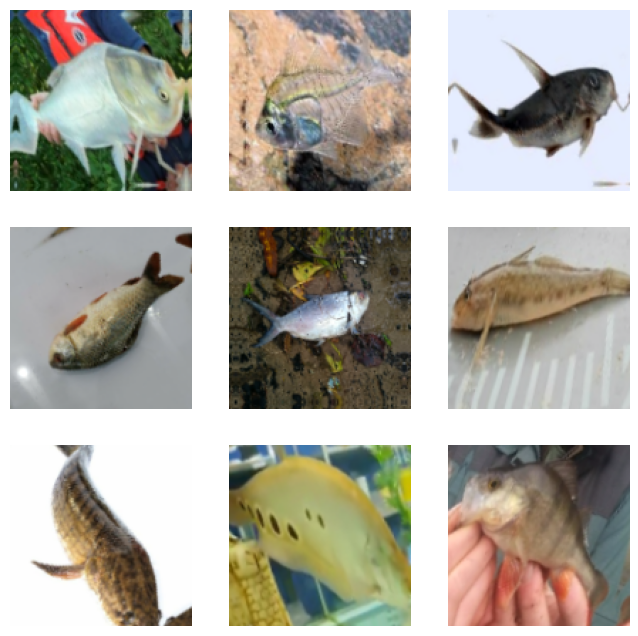

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

# Preview augmentations
plt.figure(figsize=(8, 8))
for images, _ in train_ds.take(1):
    n = min(9, images.shape[0])
    for i in range(n):
        augmented_image = data_augmentation(images, training=True)[i]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(tf.cast(augmented_image, tf.uint8))
        plt.axis('off')
plt.show()


## 5. Handle class imbalance (class weights)


In [7]:
from collections import Counter

class_to_index = {name: i for i, name in enumerate(class_names)}

counts = np.array([train_counts[name] for name in class_names])
total = counts.sum()
class_weight = {i: total / (num_classes * count) for i, count in enumerate(counts)}

class_weight

{0: np.float64(1.6640256555366912),
 1: np.float64(1.4156636173968866),
 2: np.float64(1.422741935483871),
 3: np.float64(0.9062050544483254),
 4: np.float64(1.8720288624787775),
 5: np.float64(1.4820228494623655),
 6: np.float64(1.0423017842372682),
 7: np.float64(0.7131538523728677),
 8: np.float64(0.4687782324493809),
 9: np.float64(1.3813028499843407),
 10: np.float64(0.9120140612076096),
 11: np.float64(0.23285465392534713),
 12: np.float64(2.5868035190615837),
 13: np.float64(1.086062546170894),
 14: np.float64(1.5298300381546999),
 15: np.float64(1.2425693759684462),
 16: np.float64(0.9949244304083014),
 17: np.float64(0.8920012134695116),
 18: np.float64(1.1115171370967742),
 19: np.float64(1.1115171370967742),
 20: np.float64(1.4897821313967234),
 21: np.float64(1.6353355580274378),
 22: np.float64(1.474343974594685),
 23: np.float64(0.9711549047671474),
 24: np.float64(1.8477167993297026),
 25: np.float64(0.8648887145798607),
 26: np.float64(1.1955814583898074),
 27: np.float

## 6. Build a CNN from scratch

In [8]:
from tensorflow.keras import layers, models

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

for filters in [32, 64, 128]:
    x = layers.SeparableConv2D(filters, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

cnn_model = models.Model(inputs, outputs)
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 128, 128, 32)   │           123 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 64, 64, 64)     │         2,336 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 32, 32, 128)    │         8,768 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,122 (62.98 KB)

 Trainable params: 15,674 (61.23 KB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
import os

CHECKPOINT_DIR = 'checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

class SaveEveryNEpochs(tf.keras.callbacks.Callback):
    def __init__(self, n=5, prefix='ckpt'):
        super().__init__()
        self.n = n
        self.prefix = prefix

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.n == 0:
            path = os.path.join(CHECKPOINT_DIR, f"{self.prefix}_epoch_{epoch+1}.keras")
            self.model.save(path)
            print(f"Saved checkpoint: {path}")

EPOCHS = 50

callbacks_cnn = [
    tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-5),
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(CHECKPOINT_DIR, 'best_cnn.keras'),
        monitor='val_accuracy',
        save_best_only=True
    ),
    SaveEveryNEpochs(n=5, prefix='fish_cnn')
]

history_cnn = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks_cnn
)


Epoch 1/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 58s 96ms/step - accuracy: 0.0956 - loss: 3.2820 - val_accuracy: 0.1356 - val_loss: 3.0592 - learning_rate: 0.0010
Epoch 2/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 56s 96ms/step - accuracy: 0.1371 - loss: 3.0625 - val_accuracy: 0.1345 - val_loss: 3.1817 - learning_rate: 0.0010
Epoch 3/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 64s 107ms/step - accuracy: 0.1534 - loss: 2.9921 - val_accuracy: 0.1516 - val_loss: 3.1556 - learning_rate: 0.0010
Epoch 4/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 64s 109ms/step - accuracy: 0.1696 - loss: 2.9429 - val_accuracy: 0.1901 - val_loss: 2.9714 - learning_rate: 0.0010
Epoch 5/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1855 - loss: 2.9009Saved checkpoint: checkpoints\fish_cnn_epoch_5.keras
552/552 ━━━━━━━━━━━━━━━━━━━━ 61s 103ms/step - accuracy: 0.1822 - loss: 2.8984 - val_accuracy: 0.1156 - val_loss: 3.6320 - learning_rate: 0.0010
Epoch 6/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 62s 104ms/step - accuracy: 0.1922 - loss: 2.8598 - val_accu

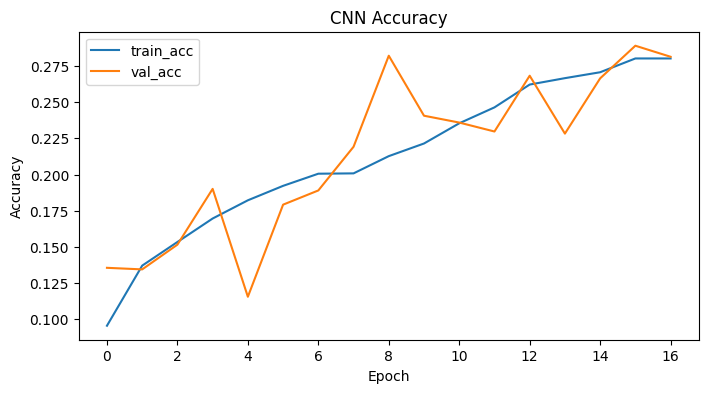

In [10]:
def plot_history(history, title):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history_cnn, 'CNN Accuracy')

## 7. Transfer Learning (MobileNetV2)
Freeze the base model, train the new classifier head, then optionally fine-tune.

In [11]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet',
    alpha=0.75
)
base_model.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

tl_model = models.Model(inputs, outputs)
tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

tl_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.75_128            │ (None, 4, 4, 1280)     │     1,382,064 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │        39,711 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,421,775 (5.42 MB)

 Trainable params: 39,711 (155.12 KB)

 Non-trainable params: 1,382,064 (5.27 MB)

Epoch 1/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step - accuracy: 0.5184 - loss: 1.7525 - val_accuracy: 0.7208 - val_loss: 0.9213 - learning_rate: 0.0010
Epoch 2/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 34s 57ms/step - accuracy: 0.7069 - loss: 0.9984 - val_accuracy: 0.7743 - val_loss: 0.7462 - learning_rate: 0.0010
Epoch 3/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - accuracy: 0.7335 - loss: 0.8736 - val_accuracy: 0.8066 - val_loss: 0.6558 - learning_rate: 0.0010
Epoch 4/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.7652 - loss: 0.7699 - val_accuracy: 0.8277 - val_loss: 0.5692 - learning_rate: 0.0010
Epoch 5/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7869 - loss: 0.7143Saved checkpoint: checkpoints\fish_tl_epoch_5.keras
552/552 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.7783 - loss: 0.7391 - val_accuracy: 0.8401 - val_loss: 0.5245 - learning_rate: 0.0010
Epoch 6/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.7892 - loss: 0.6719 - val_accuracy:

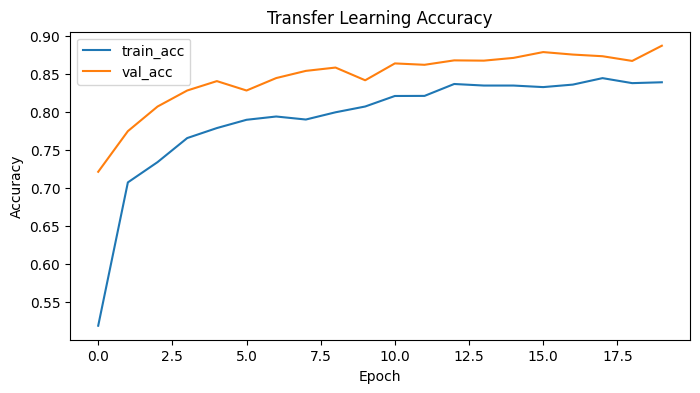

In [12]:
EPOCHS_TL = 20

callbacks_tl = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6),
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(CHECKPOINT_DIR, 'best_tl.keras'),
        monitor='val_accuracy',
        save_best_only=True
    ),
    SaveEveryNEpochs(n=5, prefix='fish_tl')
]

history_tl = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_TL,
    class_weight=class_weight,
    callbacks=callbacks_tl
)

plot_history(history_tl, 'Transfer Learning Accuracy')


### Optional fine-tuning

Epoch 1/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 66s 95ms/step - accuracy: 0.5732 - loss: 1.7158 - val_accuracy: 0.8728 - val_loss: 0.4439 - learning_rate: 1.0000e-05
Epoch 2/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 54s 90ms/step - accuracy: 0.6485 - loss: 1.2497 - val_accuracy: 0.8506 - val_loss: 0.5192 - learning_rate: 1.0000e-05
Epoch 3/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 48s 79ms/step - accuracy: 0.6986 - loss: 1.0617 - val_accuracy: 0.8368 - val_loss: 0.5648 - learning_rate: 5.0000e-06
Epoch 4/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - accuracy: 0.7030 - loss: 0.9966 - val_accuracy: 0.8281 - val_loss: 0.5897 - learning_rate: 5.0000e-06
Epoch 5/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7136 - loss: 0.9937Saved checkpoint: checkpoints\fish_tl_epoch_5.keras
552/552 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.7144 - loss: 0.9798 - val_accuracy: 0.8222 - val_loss: 0.6056 - learning_rate: 2.5000e-06


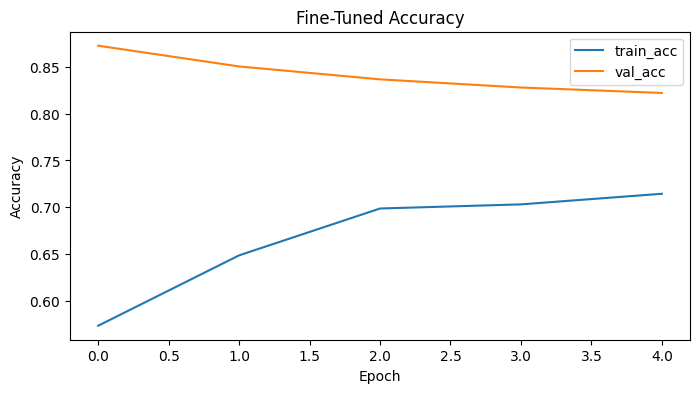

In [13]:
# Unfreeze top layers for fine-tuning (optional)
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weight,
    callbacks=callbacks_tl
)

plot_history(history_fine, 'Fine-Tuned Accuracy')


In [17]:
import sys
!{sys.executable} -m pip install scikit-learn seaborn

  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.0 MB 9.5 MB/s eta 0:00:01
   ----------------- ---------------------- 3.4/8.0 MB 10.5 MB/s eta 0:00:01
   --------------------------- ------------ 5.5/8.0 MB 10.6 MB/s eta 0:00:01
   ---------------------------------------  7.9/8.0 MB 10.7 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 10.4 MB/s  0:00:00
Using cached joblib-1.5.3-py3-none-any.whl (309 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ------- -------------------------------- 2.1/11.0 MB 11.0 MB/s eta 0:00:01
   ---------------- ----------------------- 4.5/11.0 MB 10.9 MB/s eta 0:00:01
   ----------------------- ---------------- 6.6/11.0 MB 10.9 MB/s eta 0:00:01
   -------------------------------- ------- 8.9/11.0 MB 10.9 M

## 8. Evaluation on test set

In [18]:
test_loss, test_acc = tl_model.evaluate(test_ds)
print(f'Test accuracy: {test_acc:.4f}')

111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8603 - loss: 0.4697
Test accuracy: 0.8603


111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
                       precision    recall  f1-score   support

               Bangus       0.77      0.68      0.72        34
        Big Head Carp       0.75      0.77      0.76        43
   Black Spotted Barb       0.97      0.75      0.85        40
              Catfish       0.79      0.90      0.84        62
       Climbing Perch       0.77      0.67      0.71        30
 Fourfinger Threadfin       0.78      0.92      0.84        38
       Freshwater Eel       0.80      0.87      0.83        55
       Glass Perchlet       0.97      0.84      0.90        77
                 Goby       0.94      0.85      0.89       124
            Gold Fish       1.00      0.88      0.94        41
              Gourami       0.97      0.92      0.94        63
           Grass Carp       0.92      0.91      0.92       238
 Green Spotted Puffer       1.00      1.00      1.00        22
          Indian Carp       0.80      0.98      0.88        53
  Indo-Pacif

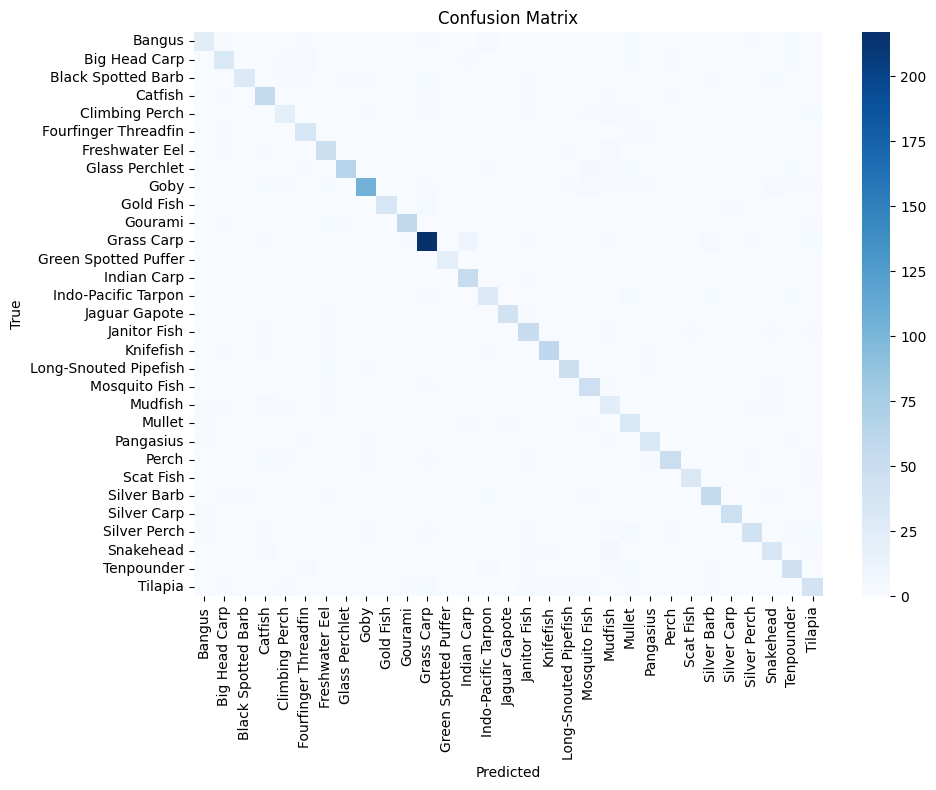

In [24]:
# Confusion matrix and classification report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_pred = np.argmax(tl_model.predict(test_ds), axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, annot=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [26]:
for l in tl_model.layers:
    print(l.name)


input_layer_3
sequential
mobilenetv2_0.75_128
global_average_pooling2d_1
dropout_1
dense_1


## 9. Interpretability (Grad-CAM)
Visualize which regions contribute to predictions.

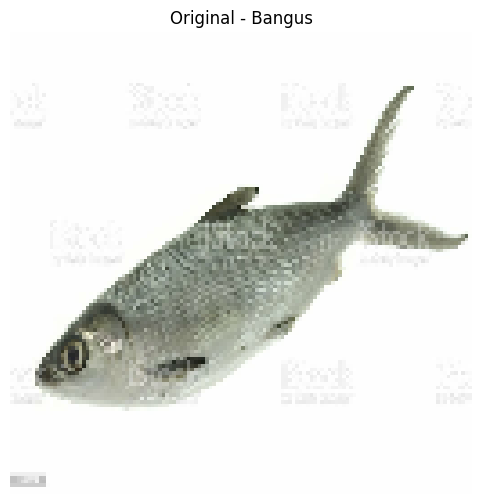

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1184\2970535749.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap('jet')


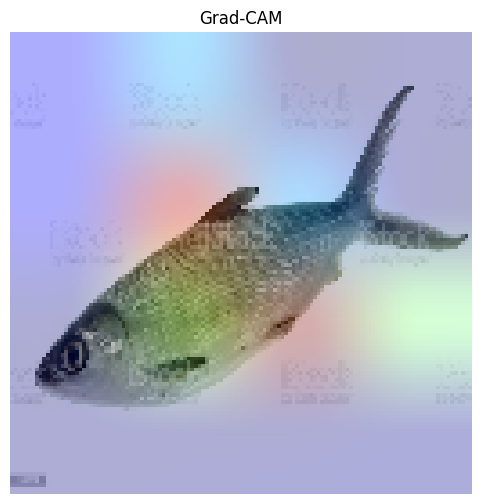

In [30]:
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model):
    # ambil layer-layer sesuai nama
    data_aug = model.get_layer('sequential')
    base = model.get_layer('mobilenetv2_0.75_128')
    gap = model.get_layer('global_average_pooling2d_1')
    dropout = model.get_layer('dropout_1')
    dense = model.get_layer('dense_1')

    with tf.GradientTape() as tape:
        x = data_aug(img_array, training=False)
        x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
        conv_outputs = base(x, training=False)

        x = gap(conv_outputs)
        x = dropout(x, training=False)
        predictions = dense(x)

        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap('jet')
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    plt.imshow(superimposed_img)
    plt.axis('off')

# Pick a sample from test set
for images, labels in test_ds.take(1):
    sample_img = images[0]
    sample_label = labels[0]

img_array = tf.expand_dims(sample_img, axis=0)
heatmap = make_gradcam_heatmap(img_array, tl_model)

plt.figure(figsize=(6, 6))
plt.imshow(sample_img.numpy().astype('uint8'))
plt.title(f'Original - {class_names[int(sample_label)]}')
plt.axis('off')
plt.show()

plt.figure(figsize=(6, 6))
display_gradcam(sample_img.numpy(), heatmap)
plt.title('Grad-CAM')
plt.show()


Notebook ini membangun alur lengkap klasifikasi gambar ikan. Dimulai dari impor library (TensorFlow, NumPy, Matplotlib, dll), penetapan seed agar hasil konsisten, serta pengaturan ukuran gambar IMG_SIZE dan BATCH_SIZE. Dataset dimuat dari folder menggunakan image_dataset_from_directory untuk membuat train_ds, val_ds, dan test_ds, lalu dioptimasi dengan shuffle dan prefetch. Ada pipeline augmentasi data (RandomFlip, RandomRotation, RandomZoom, RandomContrast) yang diletakkan di awal model sehingga augmentasi terjadi otomatis saat training.

Notebook melatih dua model: (1) CNN custom berisi separable convolution, batch normalization, ReLU, max‑pooling, global average pooling, dropout, dan output softmax; (2) model transfer learning dengan MobileNetV2 sebagai feature extractor (dibekukan), lalu pooling, dropout, dan softmax. Training dibantu callbacks seperti early stopping, pengurangan learning rate saat stagnan, serta checkpoint (termasuk callback khusus menyimpan model tiap N epoch). Setelah training, performa dievaluasi melalui kurva akurasi/loss, confusion matrix, dan classification report, kemudian ditambahkan Grad‑CAM untuk menampilkan area gambar yang paling memengaruhi prediksi.

Kesimpulan: notebook ini menunjukkan pipeline end‑to‑end untuk klasifikasi gambar ikan—mulai dari pemuatan data, augmentasi, pelatihan model (custom dan transfer learning), evaluasi, hingga interpretasi—sehingga tidak hanya meningkatkan akurasi, tapi juga memahami keputusan model.